# Section III. MOTION PLANNING
    
# Chapter 11. Extensions to Basic Planning 

**Kinodynamic planning**.  In kinodynamic planning, the robot cannot simply move the state of the world in any direction it pleases.  Instead, it must also model the dynamics of the particular system.  Kinodynamic planning can also account for time-varying goals / costs and moving obstacles. 

**Planning with uncertainty**. In many robotics applications, such as avoiding moving obstacles, a robot must integrate new information (feedback) from sensors and respond by changing its behavior.  There are two general approaches here: 1) always replan a path from scratch each iteration, 2) compute a more sophisticated plan (a *policy*) that predicts expected future errors and specifies how to react. 

**Complex interactions**. Manipulation, locomotion, and multi-agent coordination.

Most real-world problems involve some elements of all three of these extensions.  For example, to drive well in crowded environments, an autonomous vehicle needs to make fairly good predictions of other agents' behavior (potentially including how other agents will react with each other!) and incorporate these predictions into its plans.

Handling robot dynamics
-------------------------------------
In kinodynamic planning, straight-line, omnidirectional movement is not possible, and the path must respect not only the C-space obstacles but also constraints on its derivatives.  Earlier, we described particular form of such constraints for [curvature-bounded planning](GeometricMotionPlanning.ipynb#Path-planning-with-curvature-constraints).  

The kinodynamic planning formulation introduces a constraint of the form $x^\prime = f(x,u)$.  The variable $u$ is required to be in some set $u\in U\subseteq \mathbb{R}^m$.  There are a wide variety of systems that can be modeled in this form. 

A constraint directly on $x=q$ is known as a _first-order_ differential constraint.  For example, this can model the condition that only some directions of $q$ are available.  If movement is only allowed in the positive directions, we can set $q^\prime = u$. and $U = \mathbb{R}_n^+$.  In the case that $m < n$ (more precisely, the dimension of the set of velocities spanned by all controls is less than $n$), then this is known as a _nonholonomic constraint_.  Examples include the [Dubins car model](WhatAreDynamicsAndControl.ipynb#Dubins-car). 

A constraint of the form $q^{\prime\prime} = g(q,q^\prime,u)$ is a _second-order_ differential constraint, and is observed with systems that exhibit momentum.  In this case, we set $x = (q,q^\prime)$, and $x^\prime = f(x,u) = (q^\prime,g(x,u))$.  In many cases, we will want to calculate derivatives with respect to true time rather than some abstract parameter $s$.  The set of all $x=(q,q^\prime)$ is known as _phase space_. 

In general, set of all values of the variable $x$ is  referred to as the _state space_, and kinodynamic planning must be performed over this space. A feasible solution to the planning problem consists of both a state-space curve $x(s):[0,1] \rightarrow X$ and a control curve $u(s):[0,1] \rightarrow U$ satisfying

- Kinematic constraints $x(s) \in \mathcal{F}$ for all $s\in[0,1]$.
- Dynamic constraints $x^\prime(s) = f(x(s),u(s))$ for all $s\in[0,1]$.
- Initial condition $x(0) = x_I$
- Terminal condition $x(1) \in X_G$

An optimal solution may now also take into account $u$ when measuring solution cost.

Note that in many cases we would prefer to work in absolute time with the time variable denoted $t$.  In this case, the domain of the state-space and control-space trajectories is an interval $[0,T]$, and $T$ is an unknown.  We slightly modify the constraints to read:
- $x(t) \in \mathcal{F}$ for all $t\in[0,T]$
- $x^\prime(t) = f(x(t),u(t))$ for all $t\in[0,T]$
- Initial condition $x(0) = x_I$
- Terminal condition $x(t) \in X_G$
Issues with timed trajectory representations will be discussed in more detail in [Chapter 12](WhatAreDynamicsAndControl.ipynb#Trajectories-with-timing).


#### Directional constraints in planning
Examples of common directional constraints are:
- Moving forward in time
- Velocity bounds
- Making monotone progress toward a goal

Directional constraints can be handled straightforwardly using roadmap methods, since some straight-line paths in free space will still be feasible.  Rather than having an undirected graph representing bidirectional movement along each edge $(q_1,q_2)$, we will maintain a directed graph.  The motion $y(s)$ from $q_1$ to $q_2$ can be checked to see whether there exists a control $u \in U$ satisfying $y^\prime(s) = f(y(s),u)$ at all points $s\in [0,1]$.  If so, the directed edge is included in the roadmap.  If desired, the reverse edge can also be checked for the same property.

This approach works quite well with probabilistic roadmap and other sampling-based methods, because for each sampled pair of configurations, there is some nonzero likelihood that the straight line between the two satisfies the differential constraint.  Roughly speaking, this probability is the volumetric ratio of the set of valid directions vs the set of all directions.  (More specifically, we require a lower bound on this ratio holds across the configuration space.) Hence, probabilistic completeness can still be guaranteed.  With nonholonomic or second-order constraints, this likelihood is zero, and therefore sampling has no chance of success.

#### Local planning with a steering function

Let us suppose that we can devise a function $\phi(x_1,x_2)$ that, for many inputs, produces a dynamically-feasible path of states $x:[0,1] \rightarrow X$ and controls $u :[0,1] \rightarrow U$ connecting $x(0)=x_1$ and $x(1)=x_2$.  It is allowed to fail for some inputs that cannot be connected.  This type of function is known as a _steering function_, and is very useful in kinodynamic planning.  For example, in a Dubins car problem, a steering function could use the [Reeds-Shepp curves](OptimalControl.ipynb#Bang-bang-control) to produce a dynamically-feasible path between any two states.

A natural approach, particularly in roadmap methods, is then to replace the straight-line connection primitive with the steering function.  The steered path can then be checked for collision, assessed for costs, etc.  A path connecting a series of milestones is then interpreted as using the steering function to interpolate between subsequent milestones.

It requires a rather deep study to prove whether replacing straight-line connections with a particular steering function maintains completeness and optimality of a given planner.  A straight-line can be divided anywhere and the sum of lengths of the two sub-segments is exactly the same, but this property does not hold with steering functions.  For example, in the Dubins car case, the Reeds-Shepp paths produce "parallel parking" maneuvers for the car to move sideways, and over a distance a series of such maneuvers may be less effective than simply turning, moving forward, and turning back.


#### Forward planning with a simulation function

Another general approach is to define a *simulation function* (or a next-state function) and perform forward planning where paths are generated via simulation.  A simulation function takes the form
$$x_{next} = h(x,u)$$
and is usually generated by applying [integration methods](WhatAreDynamicsAndControl.ipynb#ODE-integration) to the differential constraint, for some duration of time.

In this way, sampling-based methods can be applied to the control space to expand possible future trajectories.  Tree-growing techniques are preferred for this mode of operation, and  in fact the [RRT](MotionPlanningHigherDimensions.ipynb#Rapidly-Exploring-Random-Trees-(RRTs)) algorithm was originally developed for this purpose.

The idea of kinodynamic RRT is to maintain a tree $\mathcal{T}$ of states connected by feasible paths, and the tree is grown by sampling a random control from an existing state, and then applying the simulation function.

TODO: discuss metric choice, inability to connect to goal exactly.



Handling moving obstacles and time
----------------------------------

Configuration-Time space

Obstacle models:
- constant velocity
- velocity bounded
- constant velocity + bounded velocity uncertainty
- acceleration bounded



## Planning under imperfect execution

The first type of uncertainty we shall consider is _motion uncertainty_, which means that as the robot executes a desired motion, its configuration may be knocked off course.  This type of uncertainty is a dominant factor in drones, underwater robots, and off-road driving, but exists for all robots to some extent.  The simplest way to account for motion uncertainty is using a path tracking feedback controller, which we shall study in more detail in [Chapter 12](RobotControl.ipynb#Trajectory-following).  But such a controller only makes local course corrections, and will not be cognizant of obstacles and other global information.

In a *replanning* approach, the robot simply recomputes plans every iteration, using the current observed state as the input. One severe issue with replanning is that the plan needs to be recomputed in real time (i.e, within a fixed time budget.)  This budget is usually relatively small, say, one second or a fraction of a second.  We have already mentioned generate-and-score heuristics and potential fields as obstacle avoidance techniques that are typically quite computationally light, but are incomplete.  For low-dimensional problems like mobile robot navigation, replanning is not usually much of a problem, since geometric planners are usually quite fast. However, for industrial manipulators, legged robots, or multi-robot coordination, replanning may be much more computationally expensive.  In complex problems, to approach real-time replanning requires generating representations offline (i.e., precomputed before execution) that lead to fast replanning online (i.e., during execution).  For example, PRM can be precomputed for a given environment, with and the optimal path between any two points in this environment can be computed quickly using search. The Dynamic Window approach described below is a hybrid approach that precomputes a well-designed, global navigation function, and replans local, dynamically-feasible paths to descend this function.

An alternative to replanning is to precompute the appropriate way to react to *any* future disturbance. This calls for replacing our search-based model of planning with a different planning paradigm, which is known as the Markov Decision Process (MDP).

### Navigation functions and the Dynamic Window Approach

A useful application of grid search is to compute a *navigation function* that, for each point on the grid G, represents the cost of the shortest path to reach the goal.  This is done by running Dijkstra's algorithm backward, starting from the goal.  This operates in a "brush fire" manner that grows uniform-cost fringes around the goal node. We do not terminate when the algorithm reaches the start state, but rather let the algorithm propagate to all reachable states.  Then, for each node $v$ the navigation function stores the cost $c(v)$ from the goal to the node, which by symmetry is exactly the cost from the node to the goal.

The advantage of this approach is that the navigation function can be solved once and cached.  Then, the optimal action at each state $x$ is the direction that descends the navigation function the fastest, i.e., $x$ should move toward $\arg \min_{v \in N(x)} c(v)$, where $N(x)$ gives the nodes of the grid in some neighborhood of $x$.  If the robot is knocked off of its course, then it can simply examine the navigation function value at its new location, only having to check for the local node with minimum value.

A useful application for this approach is to compute long-range estimates of navigation cost for dynamic mobile robots or even legged robots.  Because a mobile robot may have orientation and velocity, the navigation function value is not perfect particularly locally, where it may need to perform backing up and turning maneuvers.  In the long run, however, the robot moves approximately like a point traveling at constant speed.  So, a very practical approach is to generate short local trajectories that accurately respect the dynamic behavior of the robot, including inertia, acceleration limits, and turning limits, but measure the progress of each trajectory toward achieving long-term goals using the navigation function value at its endpoint.  Collisions along those trajectories should also be checked to reject infeasible motions, and the trajectory is chosen that minimizes a combination of short-term and long-term costs. An example implementation is shown in [Section 1.3](#Dubins-car-example).


### Markov Decision Processes (MDPs)

#### Discrete MDP definition

#### Bellman equation

#### Value iteration and policy iteration

### Dubins car example

An example of DWA and MDPs is shown in the code below. 

1. The first cell calculates a standard navigation function for an environment with block obstacles.
2. The second cell shows how quickly optimal paths and costs can be computed across the state space, once the navigation function has been computed. 
3. The third cell steers a Dubins car model (i.e., a curvature-bounded mobile robot) toward the goal using a DWA-style method.  At each iteration, this implementation replans with randomly-generated trajectories at a fixed time horizon. The scoring function is tuned for good performance, and its score includes the navigation function value, penalties for performing reversing maneuvers, and also tries to align the forward direction of the vehicle with the descent direction for the navigation function.
4. The fourth cell shows that with disturbances, the overly optimistic navigation function can cause replanning with DWA to collide into obstacles (red paths) or fail to reach the goal (yellow paths).

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
grid_search: search returned no path, taking time: 3.0099875926971436


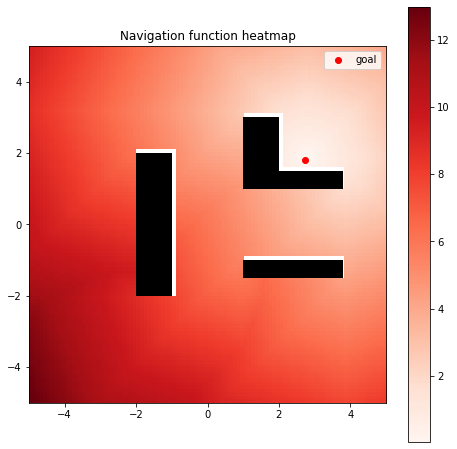

In [303]:
#Jupyter notebook must be run from this directory for this code to work.
%load_ext autoreload
%autoreload 2
%matplotlib inline

from code.utilities import graph,example_graphs
from code.planning import grid_search
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math

class NavigationFunction:
    """Stores results for a navigation function to the target xgoal"""
    def __init__(self,xgoal,xmin,xmax,resolution,
                 obstacle_test,obstacle_edge_test=None,
                 diagonals=True,verbose=0):
        self.xgoal = xgoal
        self.xmin = xmin
        self.xmax = xmax
        self.resolution = resolution
        #precompute costs-to-go across the grid
        _,self.distances,self.predecessors = grid_search.grid_search(xgoal,lambda x:False,xmin,xmax,resolution=resolution,
                              obstacle_test = obstacle_test,
                              obstacle_edge_test = obstacle_edge_test,
                              diagonals=diagonals,implicit=True,
                              verbose=verbose)
    def get_cost(self,x):    
        return grid_search.optimal_path_cost(x,self.distances,self.predecessors,self.xgoal,self.xmin,self.xmax,self.resolution)
        
    def get_path(self,x):
        prev = grid_search.optimal_path(x,self.distances,self.predecessors,self.xgoal,self.xmin,self.xmax,self.resolution)
        if prev is None: return None
        return prev[::-1]

#define search problem and obstacle boxes
xgoal = (2.74,1.8)
xmin = [-5,-5]
xmax = [5,5]
resolution = 0.1
obstacles = [([-2,-2],[-1,2]),
             ([1,1],[2,3]),
             ((1,1),(3.8,1.5)),
             ((1,-1.5),(3.8,-1))]
def in_obstacles(x):
    global obstacles
    for a,b in obstacles:
        if a[0] <= x[0] <= b[0] and a[1] <= x[1] <= b[1]:
            return True
    return False

nav_fn = NavigationFunction(xgoal,xmin,xmax,resolution,in_obstacles,verbose=1)

#plot start, goal, and costs-to-go
def setup_dwa_plt():
    plt.figure(figsize=(8,8))
    plt.xlim(xmin[0],xmax[0])
    plt.ylim(xmin[1],xmax[1])
    #plot obstacles
    for a,b in obstacles:
        patch = patches.Rectangle(a,b[0]-a[0],b[1]-a[1],facecolor='k',zorder=1)
        plt.gca().add_patch(patch)
    plt.scatter([xgoal[0]],[xgoal[1]],c='r',zorder=2,label='goal')
    plt.gca().set_aspect('equal', 'box')

setup_dwa_plt()

#plot costs-to-go
distance_img = np.ones([int(math.floor((b-a)/resolution)) for (a,b) in zip(xmin,xmax)])*float('inf')
for (k,v) in nav_fn.distances.items():
    if isinstance(k,str): continue
    distance_img[k] = v
plt.imshow(distance_img.T,cmap=plt.cm.Reds, interpolation='none', extent=[xmin[1],xmax[1],xmax[0],xmin[0]])
plt.title("Navigation function heatmap")
plt.legend()
plt.colorbar()
plt.show()

Time to compute 100 paths: 0.10854601860046387
Time to compute 100 optimal costs: 0.011766433715820312


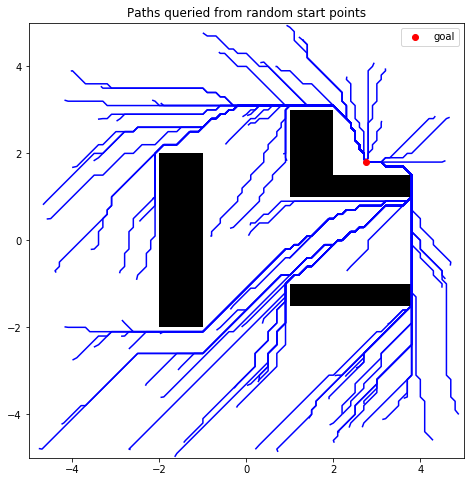

In [304]:
#Now can get optimal paths for many states quickly using the `nav_fn`
#`get_path` method.  Run this after the prior cell.
import random
import time

N = 100
starting_points = []
for i in range(N):
    x = [random.uniform(a,b) for (a,b) in zip(xmin,xmax)]
    starting_points.append(x)
t0 = time.time()
paths = []
for x in starting_points:
    path = nav_fn.get_path(x)
    paths.append(path)
t1 = time.time()
print("Time to compute",N,"paths:",t1-t0)
t0 = time.time()
for x in starting_points:
    c = nav_fn.get_cost(x)
t1 = time.time()
print("Time to compute",N,"optimal costs:",t1-t0)

setup_dwa_plt()

#plot paths
for p in paths:
    if p is not None:
        plt.plot([x[0] for x in p],[x[1] for x in p],c='b',zorder=1)
plt.legend()
plt.title("Paths queried from random start points")
plt.show()

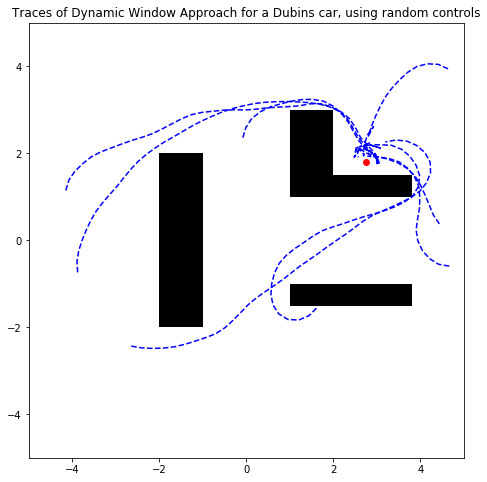

In [305]:
# This shows the dynamic window approach for a Dubins car vehicle
from code.control.examples.dubins import DubinsCar

dubins = DubinsCar(-2,2)
distance_resolution = 0.25
edge_check_divs = 5

def sample_u():
    return [random.choice([-1,1])*distance_resolution,random.uniform(*dubins.turnRateRange)]
    #return [random.choice([-1,1])*distance_resolution,random.choice([dubins.turnRateRange[0],dubins.turnRateRange[0]*0.5,0,dubins.turnRateRange[1]*0.5,dubins.turnRateRange[1]])]

def score(x,upath,distance_weight=0.0):
    """A pretty well-tuned scoring function for DWA, for this particular Dubins car model"""
    if len(upath) == 0:
        return nav_fn.get_cost(x[:2])
    dir_sign = np.sign(upath[0][0])
    sign_changes = 0
    drive_dist = 0
    executed_steps = 0
    #simulate the path, perform collision checking along it. Stop when a collision is found.
    #also, count the number of direction changes
    for u in upath:
        utemp = [u[0]/edge_check_divs,u[1]]
        infeasible = False
        for i in range(edge_check_divs):
            xn = dubins.next_state(x,utemp)
            if in_obstacles(xn):
                infeasible = True
                break
            x = xn
            drive_dist += abs(utemp[0])
            if dir_sign != np.sign(utemp[0]):
                sign_changes += 1
                dir_sign!= np.sign(utemp[0])
        if infeasible:
            break
        executed_steps += 1

    #compute the heading error from the navigation function's gradient drection
    heading_error = 0
    path = nav_fn.get_path(x[:2])
    if path is not None and len(path) > 1:
        d = (path[1]-path[0])/np.linalg.norm(path[1]-path[0])
        dx = (math.cos(x[2]),math.sin(x[2]))
        heading_error = math.acos(np.dot(d,dx))
    return drive_dist*distance_weight*0.2 + sign_changes*0.5 + nav_fn.get_cost(x[:2]) + heading_error*0.1 + 1.0*(len(upath)-executed_steps)

def ufunc_traj(t,x,u_path):
    if t > len(u_path):
        return [0,0]
    return u_path[int(math.floor(t))]

#dynamic window approach with randomly sampled paths
n_constant_samples = 20
n_random_samples = 20
horizon = 5

def ufunc_random_dynamic_window(t,x):
    s0 = score(x,[])
    if s0 < 0.25:
        return (0,0)
    ubest = (0,0)
    distance_weight = 1.0 / (s0 + 0.01)
    sbest = s0 + horizon*distance_weight
    for i in range(n_constant_samples+n_random_samples):
        h = horizon
        #when getting close to the goal, add stopping as an option
        if s0 < 0.5:
            h = random.randint(1,horizon)
        if i < n_constant_samples:
            u_path = [sample_u()]*h
        else:
            u_path = [sample_u() for i in range(h)]
        s = score(x,u_path,distance_weight)
        if s < sbest:
            sbest = s
            ubest = u_path[0]
    if in_obstacles(dubins.next_state(x,ubest)):
        return (0,0)
    return ubest

setup_dwa_plt()

#can play around with this random seed to see different examples
random.seed(1234)
for n in range(10):
    xstart = (random.uniform(xmin[0],xmax[0]),random.uniform(xmin[1],xmax[1]),random.uniform(0,math.pi*2))
    if in_obstacles(xstart[0:2]):
        continue
    
    xpath = dubins.simulate(xstart,ufunc_random_dynamic_window,T=40,dt=1)['x']
    if any(in_obstacles(x[0:2]) for x in xpath):
        c = 'r'
    elif np.linalg.norm(np.array(xpath[-1][0:2])-xgoal) < 1:
        c = 'b'
    else:
        c = 'y'
    plt.plot([x[0] for x in xpath],[x[1] for x in xpath],c=c,linestyle='--')
    
plt.title("Traces of Dynamic Window Approach for a Dubins car, using random controls")
plt.show()

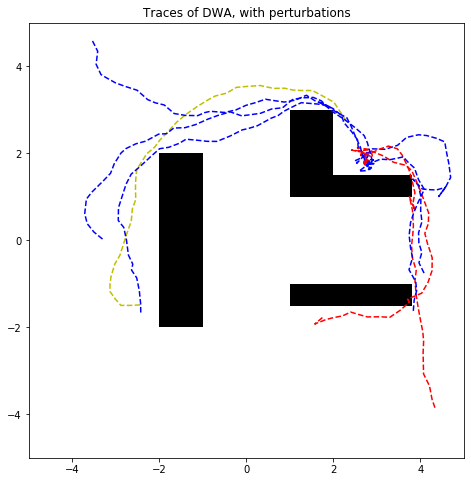

In [306]:
class PerturbedDubinsCar(DubinsCar):
    def simulate(self,x0,ufunc,T=1,dt=1e-2):
        x = x0
        res = dict((idx,[]) for idx in ['t','x','u','dx'])
        t = 0
        while t < T:
            u = ufunc(t,x)
            assert len(u) == 2
            u = list(u)
            u[0] = max(self.distanceRange[0],min(self.distanceRange[1],u[0]))
            u[1] = max(self.turnRateRange[0],min(self.turnRateRange[1],u[1]))
            #print t,x,u
            dx = self.derivative(x,u)
            res['t'].append(t)
            res['x'].append(x)
            res['dx'].append(dx)
            res['u'].append(u)
            uprime = [u[0]*dt,u[1]]
            xn = self.next_state(x,uprime) + np.multiply(np.random.normal(size=3),[0.05*math.sqrt(dt),0.05*math.sqrt(dt),0.05*math.sqrt(dt)])
            x = xn
            t += dt
        return res

perturbed_dubins = PerturbedDubinsCar(*dubins.turnRateRange)

setup_dwa_plt()

#can play around with this random seed to see different examples
random.seed(1235)
for n in range(10):
    xstart = (random.uniform(xmin[0],xmax[0]),random.uniform(xmin[1],xmax[1]),random.uniform(0,math.pi*2))
    if in_obstacles(xstart[0:2]):
        continue
    
    xpath = perturbed_dubins.simulate(xstart,ufunc_random_dynamic_window,T=40,dt=1)['x']
    if any(in_obstacles(x[0:2]) for x in xpath):
        c = 'r'
    elif np.linalg.norm(np.array(xpath[-1][0:2])-xgoal) < 1:
        c = 'b'
    else:
        c = 'y'
    plt.plot([x[0] for x in xpath],[x[1] for x in xpath],c=c,linestyle='--')
    
plt.title("Traces of DWA, with perturbations")
plt.show()

Planning under partial and noisy information
-----------------------------

Throughout this chapter we have assumed that the information about environmental
obstacles is complete and correct. However, this is rarely the case, and
this can be problematic. If some obstacles are unobserved or imperfectly
sensed, then the robot may happily start to execute its solution path
(which is feasible according to the robot's model), but in reality the
robot might end up colliding! Although it is possible to devise
planning algorithms that are able to cope with these types of unknowns,
these are relatively complex and typically beyond the scope of an
introductory robotics course. Instead, we shall see how we might handle
these issues in practice by modifying how a planner is invoked during
its sense-plan-act loop.

To handle missing data, one straightforward and effective approach is to
ensure that the robot senses around it as it moves, and then replans
when the previous plan becomes invalidated by a newly-sensed obstacle.
With an *optimistic replanning* strategy, the robot assumes that any
areas that have not been observed are obstacle-free. Then, its first
path will navigate around local obstacles and then proceed straight to
the goal. As it starts to execute the path, it will update its map
representation using sensor data, and then a *plan execution* module
will repeatedly verify whether the current plan is still valid. If an
obstacle is observed in the previously unseen location, then the robot
will replan and find an alternate route. Another variant of this
approach would simply replan at regular intervals. This would work best
with a fast planner, so that new obstacles can be reacted to quickly, as
well as an optimizing planner, to ensure that the paths do not vary too
wildly as more sensor data is incorporated.

One question that must be addressed is whether the local map is properly
updated to handle obstacles. For example, if a human were to walk
through a building backwards it would be very likely to bump into
something or to trip! If the robot's sensor were omnidirectional or
always oriented in its direction of motion, then as it approaches an
unobserved part of the world, then yes, the new sensor data will fill in
the map. This is also an effective strategy to handle slowly moving
obstacles.

To handle noisy observations, _collision margins_ are a simple and often effective approach.
The idea is simply is to fatten the obstacles (or the robot geometry)
used by the planner by some margin of error $\epsilon$. Hence, path
produced by the planner will never pass within $\epsilon$ distance of
the sensed obstacles. If the threshold $\epsilon$ is chosen
appropriately to encapsulate all of the errors of the sensor at hand,
the robot will not collide while executing. However, if the threshold is
made too large, the planner may fail to find a path through a narrow
passage.

There are a few solutions in the latter case: either use sensors with
higher accuracy, use *probabilistic costs* that penalize paths
that are likely to collide, or use *sensor-based motion planning*
techniques that predict and reason about how future sensor measurements
may change the robot's map, and how robots can use sensor feedback
during low-level motions rather than just following a path. Sensor-based
planning techniques reason in an *information space* to predict how
future measurements could lead to narrow passages opening up in the map
in the future. However, these methods are generally more computationally
complex because the space of maps may be enormous.

Multi-agent planning
--------------------

Computational complexity (NP hard on graph)

Deadlock

Coordination graph

Manipulation planning and locomotion planning
---------------------------------------------

Duality between manipulation and locomotion

Planning on closed chain manifolds

Grasp planning.

Multi-modal planning. Transitions

Task and motion planning
------------------------

AI planning and scheduling

Semantics

Knowledge base
